In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.vision.gan import *

Fastai version in this notebook:

In [40]:
__version__

'1.0.48.dev0'

In [38]:
git log -3

commit 4022362f0132640375afd15b7dcb7d932d9740d0
Author: PPPW <pei.wang.fudan@gmail.com>
Date:   Fri Mar 8 19:43:35 2019 -0500

    Fix gan to adapt callback API changes

commit a8ff26a925511902353136751a05f3b68fa3fcd9
Author: Konstantin Dorichev <kdorichev@gmail.com>
Date:   Sat Mar 9 02:19:47 2019 +0300

    Added earlier committed tests to this_tests. (#1790)

commit 5f4963869dfd01d184468f8871218344b3b0bad1
Author: Aaron Swaving <aaron.swaving@gmail.com>
Date:   Sat Mar 9 00:19:25 2019 +0100

    updated wide resnet docs (#1792)


## data

In [3]:
embedding = torch.load('embedding.pkl')

In [4]:
class Txt2ImgYItemList(ItemList):
    def __init__(self, items, embedding=embedding, **kwargs):
        super().__init__(items, **kwargs)        
        self.embedding = embedding 
        self.copy_new.append('embedding')

    def get(self, i): 
        fn = self.items[i]
        key = fn.name.split('.')[0] + '.txt'
        # return: embedding, image
        return self.embedding[key].cuda(), open_image(fn, convert_mode='RGB')      
    
    def reconstruct(self, t):
        return Image(t.float().clamp(min=0,max=1))
        
    def show_xys(self, xs, ys, imgsize=4, figsize=None, **kwargs):
        raise NotImplementedError

    def show_xyzs(self, xs, ys, zs, imgsize=4, figsize=None, **kwargs):
        raise NotImplementedError

In [5]:
class Txt2ImgXItemList(ItemList):    
    _label_cls = Txt2ImgYItemList

    def __init__(self, items, embedding=embedding, **kwargs):
        super().__init__(items, **kwargs)        
        self.embedding = embedding 
        self.copy_new.append('embedding')
        
    def get(self, i): 
        fn = self.items[i]
        key = fn.name.split('.')[0] + '.txt'        
        # return: embedding, wrong image
        return self.embedding[key].cuda()#, self.get_wrong_image(i)
    
    def get_wrong_image(self, i):        
        cat = '_'.join(self.items[i].name.split('_')[:-3])
        idx = np.random.randint(len(self))

        if not self.items[idx].name.startswith(cat):
            return open_image(self.items[idx], convert_mode='RGB')

        return self.get_wrong_image(i)
            
    def reconstruct(self, t):
        raise NotImplementedError            
    
    def show_xys(self, xs, ys, imgsize=4, figsize=None, **kwargs):
        raise NotImplementedError

    def show_xyzs(self, xs, ys, zs, imgsize=4, figsize=None, **kwargs):
        raise NotImplementedError

In [6]:
data = (Txt2ImgXItemList
            .from_folder('data/images/')
            #.from_folder('sample/images/train')
            #.use_partial_data()
            #.split_by_rand_pct(valid_pct=0.1)
            .split_none()            
            .label_from_func(noop)
            .databunch(bs=128, num_workers=0)) # num_workers: for Windows
            # TODO: normalize?

In [7]:
data.train_dl.dl.pin_memory = False  # why?

In [8]:
item = next(iter(data.train_dl))

In [9]:
item[0][0].shape, item[0][1].shape, item[1][0].shape, item[1][1].shape  

(torch.Size([400, 1, 1]),
 torch.Size([400, 1, 1]),
 torch.Size([128, 400, 1, 1]),
 torch.Size([128, 3, 64, 64]))

## model

In [10]:
def avg_flatten(x): return x.mean(0).view(1)

def AvgFlatten(): return Lambda(avg_flatten)  # now can pickle

In [11]:
def squeezer(in_dim, out_dim):
    return nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.BatchNorm1d(out_dim),
            nn.LeakyReLU(0.2, inplace=True)
        )

In [12]:
class Txt2ImgGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.generator = basic_generator(in_size=64, n_channels=3, noise_sz=228)
        self.squeezer = squeezer(400, 128)
    
    def forward(self, embedding, fake_image=None):        
        em_s = self.squeezer(embedding.view(embedding.size(0), -1))
        em_s = em_s[:,:,None,None]
        em_noise = torch.cat([em_s, torch.randn(em_s.size(0),100,1,1).cuda()], 1)
        # return: (embedding, fake image)
        return embedding, self.generator(em_noise)

In [13]:
class Txt2ImgCritic(nn.Module):
    def __init__(self):
        super().__init__()
        critic = basic_critic(in_size=64, n_channels=3)
        self.body = nn.Sequential(*list(critic.children())[:-2])
        self.head = nn.Sequential(conv2d(640, 1, 4, padding=0), 
                                  AvgFlatten())
        self.squeezer = squeezer(400, 128)
        
    def forward(self, embedding, image):
        x = self.body(image)                     # (512,4,4)
        em_s = self.squeezer(embedding.view(embedding.size(0), -1)) 
        em_s = em_s[:,:,None,None]               # (128,1,1)
        em_s = em_s.repeat(1,1,4,4)              # (128,4,4)
        x = torch.cat([x, em_s], 1)              # (640,4,4)
        x = self.head(x)
        return x

In [14]:
class Txt2ImgLoss(GANModule):    
    def __init__(self, gan_model):
        super().__init__()
        self.gan_model = gan_model

    def generator(self, output, *target):
        # output: (embedding, image)
        # target: (embedding, image)
        fake_pred = self.gan_model.critic(*output)        
        return fake_pred.mean()

    def critic(self, real_pred, embedding, wrong_img=None):
        # real_pred: (1,)
        fake = self.gan_model.generator(embedding.requires_grad_(False))
        # fake: (embedding, fake image)
        fake[1].requires_grad_(True)
        fake_pred = self.gan_model.critic(*fake)  
        #wrong_pred = self.gan_model.critic(fake[0], wrong_img)
        return real_pred.mean() - fake_pred.mean() #- wrong_pred.mean()

In [15]:
class Txt2ImgGANTrainer(GANTrainer):    
    def on_backward_begin(self, last_loss, last_output, **kwargs):        
        last_loss = last_loss.detach().cpu()
        if self.gen_mode:
            self.smoothenerG.add_value(last_loss)
            self.glosses.append(self.smoothenerG.smooth)
            # last_output: (embedding, image)
            self.last_gen = last_output[1].detach().cpu()
        else:
            self.smoothenerC.add_value(last_loss)
            self.closses.append(self.smoothenerC.smooth)

In [16]:
generator = Txt2ImgGenerator()
critic = Txt2ImgCritic()

In [17]:
gan = GANModule(generator, critic)
loss_func = Txt2ImgLoss(gan)
switcher = partial(FixedGANSwitcher, n_crit=5, n_gen=1)

In [18]:
learn = Learner(data, gan, loss_func=loss_func, 
                opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.,
                callback_fns=[switcher], path='.')

In [19]:
trainer = Txt2ImgGANTrainer(learn, clip=0.01, switch_eval=False, show_img=True)
learn.gan_trainer = trainer
learn.callbacks.append(trainer)

## train

In [20]:
_ = learn.load('m5', purge=False)  # purge not working? 

In [21]:
learn.opt_func = partial(optim.Adam, betas = (0.5,0.99))

In [22]:
learn.opt_func, learn.callback_fns

(functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.5, 0.99)),
 [functools.partial(<class 'fastai.basic_train.Recorder'>, add_time=True),
  functools.partial(<class 'fastai.vision.gan.FixedGANSwitcher'>, n_crit=5, n_gen=1)])

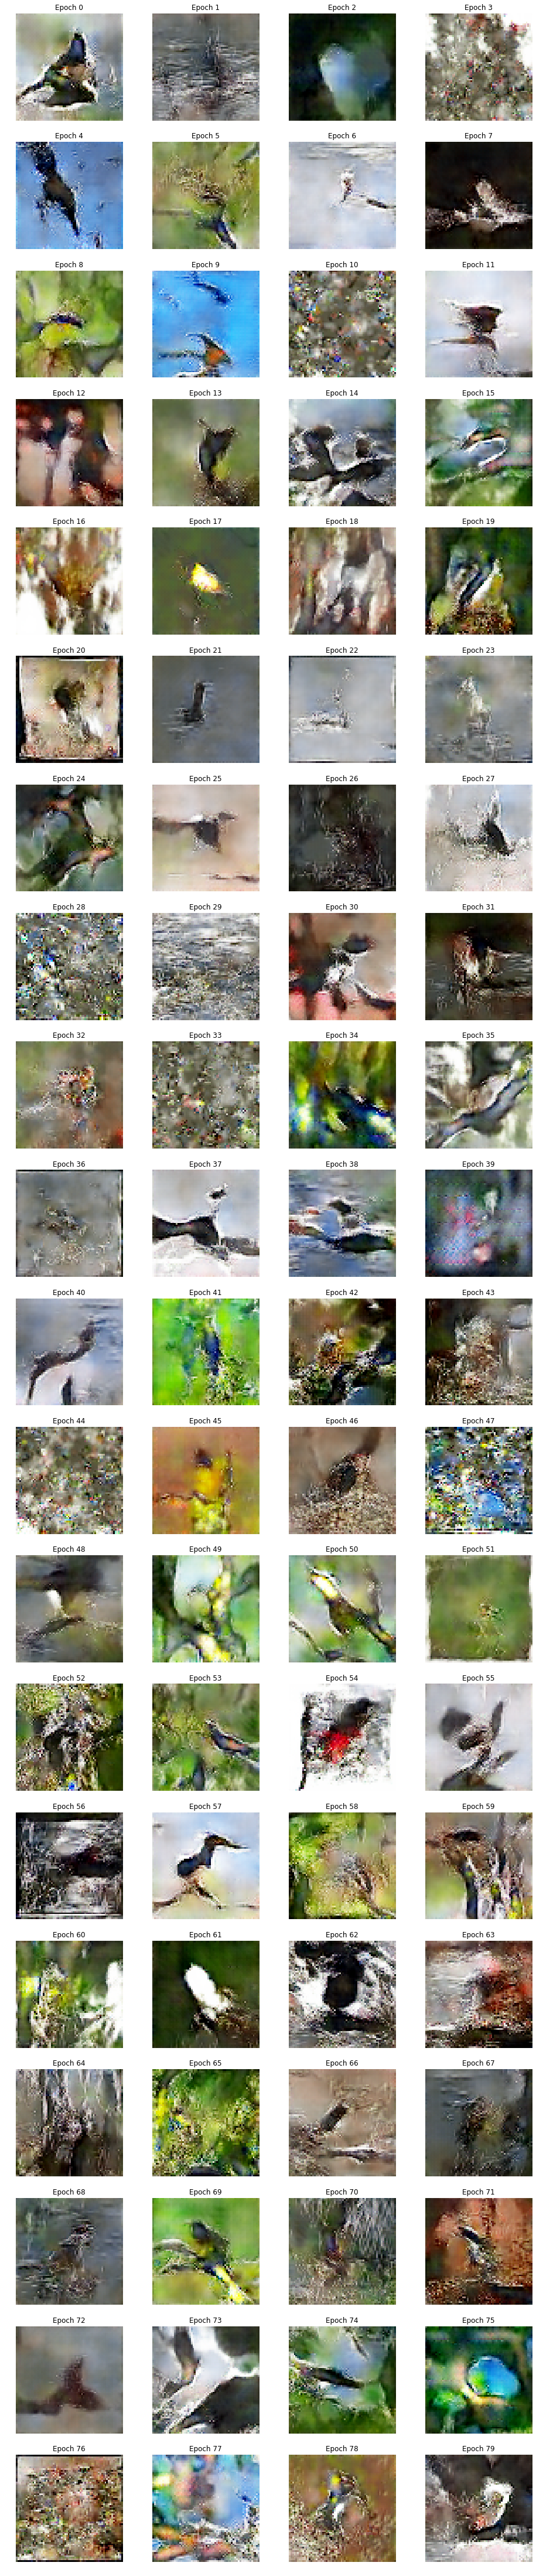

In [27]:
learn.fit(80, 2e-4)

In [28]:
learn.save('m5')

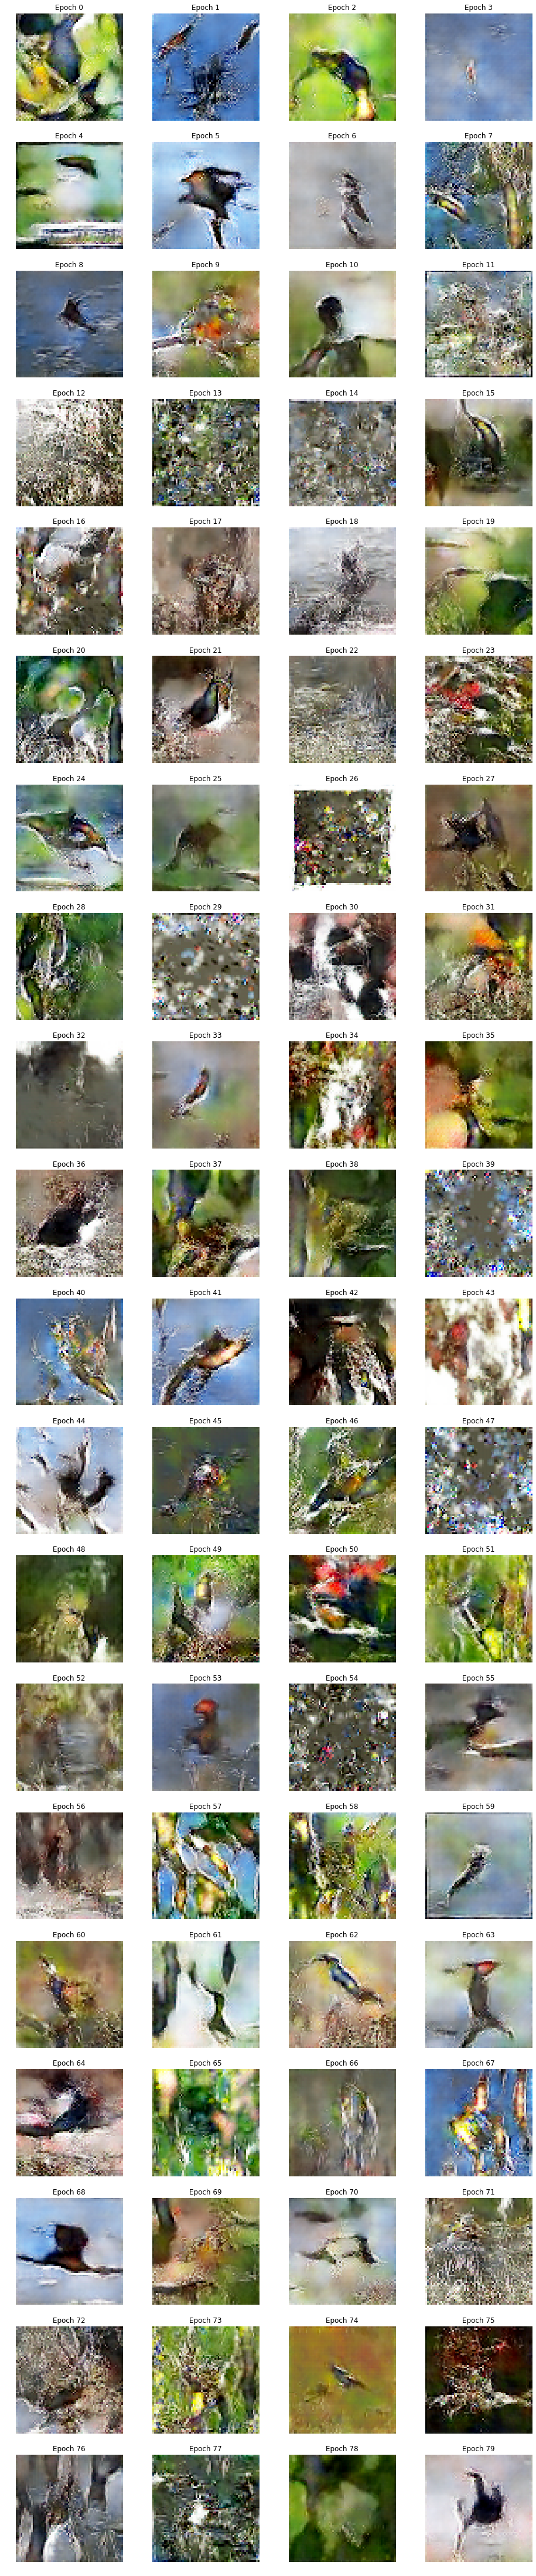

In [29]:
learn.fit(80, 2e-4)

In [30]:
learn.save('m5')

In [ ]:
gc.collect()
torch.cuda.empty_cache()

## Test

In [41]:
torch.save(learn.model.generator.state_dict(), 'models/gan_gen.pkl')

In [23]:
model = Txt2ImgGenerator()
model.load_state_dict(torch.load('models/gan_gen.pkl'))
_ = model.to('cuda')
_ = model.eval()

In [99]:
em = embedding['Summer_Tanager_0001_139289_0.txt'].cuda()

In [25]:
next(model.parameters()).device, em.device

(device(type='cuda', index=0), device(type='cuda', index=0))

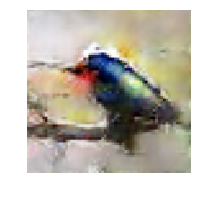

In [80]:
with torch.no_grad():
    _, img = model(em[None])
    Image(img[0].cpu().float().clamp(min=0,max=1)).resize(100).show()

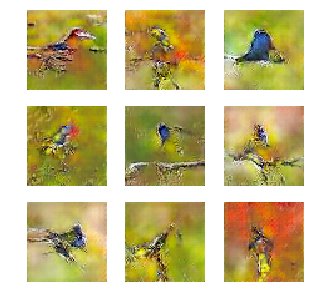

In [205]:
em = embedding['Sayornis_0002_98596_0.txt'].cuda()
f, ax = plt.subplots(3, 3, figsize=(5,5))
with torch.no_grad():
    for i in range(9):
        _, img = model(em[None])
        gen = Image(img[0].cpu().float().clamp(min=0,max=1))
        gen.save(f'tmp/test_{i}.jpg')
        gen.show(ax.ravel()[i])

In [98]:
with open('tmp/sample.txt') as f:
    for line in f:
        des = line.strip()
        em = embedding[f'{des}.txt'].cuda()
        with torch.no_grad():
            for i in range(9):
                _, img = model(em[None])
                Image(img[0].cpu().float().clamp(min=0,max=1)).save(f'tmp/gen/{des}_{i}.jpg')